In [282]:
import jax.numpy as np
from jax.experimental.host_callback import id_tap
import numpy as onp
from jax import random, lax, jit, vmap
from numpy.random import randn
import matplotlib.pyplot as plt
from tqdm import tqdm
from jax.numpy.linalg import inv, norm
from functools import partial
from timer import *

### Data generation

In [414]:
def get_dataset(seed, x_dim, freq, samples, scale=1, sep=1):
    onp.random.seed(seed)
    mu_0 = randn(x_dim,1) # mean of class 0
    mu_1 = randn(x_dim,1) # mean of class 1
    # print(mu_0, mu_1)
    sig = randn(x_dim,x_dim)/np.sqrt(x_dim) # covariance of class 0
    Sigma = sig@sig.T
    class_0 = scale * mu_0 + sig@randn(x_dim,int(samples*(1-freq)))
    class_1 = scale * mu_1 + sig@randn(x_dim,int(samples*freq))
    X = onp.concatenate((class_0,class_1),axis=1)
    Y = onp.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1

    return (class_0, class_1, X, Y, mu_0, mu_1, Sigma)

seed = 0
x_dim = 5 # dimension of observations
freq = 0.1 # frequency of class 1 samples
samples = 10000 # number of data points
scale = 0.5
items = get_dataset(seed, x_dim, freq, samples, scale)
items = tuple(map(lambda x: np.array(x), items))
(class_0, class_1, X, Y, mu_0, mu_1, Sigma) = items

In [415]:
# idx = random.permutation(key,samples)
# X = X[:,idx]
# Y = Y[:,idx]

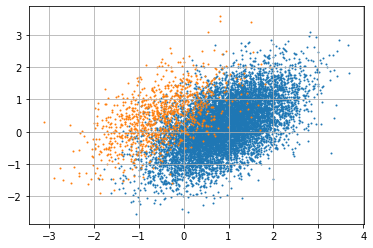

In [416]:
plt.scatter(class_0[0],class_0[1],s=1)
plt.scatter(class_1[0],class_1[1],s=1)
plt.grid()
plt.show()

### Optimal solution

In [417]:
w_opt = np.linalg.inv(Sigma)@(mu_0-mu_1)
w_opt = w_opt/np.sqrt(w_opt.T@(Sigma)@w_opt)

In [418]:
obj_opt = (w_opt.T@(mu_0-mu_1))**2

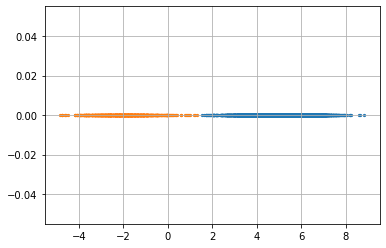

In [419]:
plt.scatter(w_opt.T@class_0,np.zeros((w_opt.T@class_0).shape),s=5)
plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
plt.grid()
plt.show()

In [420]:
acc_0 = np.sum(w_opt.T@class_0 > 1/2 * w_opt.T@(mu_0+mu_1))
acc_1 = np.sum(w_opt.T@class_1 < 1/2 * w_opt.T@(mu_0+mu_1))
print(f"Accuracy is {100*(acc_0+acc_1)/samples}%")

Accuracy is 97.95999908447266%


### Offline algorithm

In [421]:
def square(x): return x**2

def run_offline(items, iters, lrs):
    
    class_0, class_1, X, Y, mu_0, mu_1, Sigma = items
    eta, gamma = lrs
    samples = class_0.shape[1] + class_1.shape[1]
    
    w_opt = inv(Sigma)@(mu_0-mu_1)
    w_opt /= np.sqrt(w_opt.T@(Sigma)@w_opt)
    
    err = onp.zeros(iters)
    acc = onp.zeros(iters)
    
    w = onp.random.randn(x_dim,1)/np.sqrt(x_dim)
    l = onp.ones((1,1))
    w = np.array(w)
    l = np.array(l)
    
    @jit
    def fit(w, l):
        w += eta * (mu_0-mu_1 - l*Sigma@w)
        l += gamma * w.T@Sigma@w - np.ones((1,1))
        return w,l
    
    @jit
    def track(w, l, class_0, class_1, mu_0, mu_1):
        err_i = (norm(w[:,0] - w_opt[:,0]))**2
        acc_i = ((w.T@class_0 > 1/2 * w.T@(mu_0+mu_1)).sum()  + (w.T@class_1 < 1/2 * w.T@(mu_0+mu_1)).sum())/samples
        return err_i, acc_i
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l)
        err_i, acc_i = track(w, l, class_0, class_1, mu_0, mu_1)
        err[i_iter] = err_i
        acc[i_iter] = acc_i
        
    return w_opt, w, l, err, acc

In [422]:
eta = 1e-2; gamma=1e2*eta; iters = int(1e5)

In [423]:
w_opt, w, l, err, acc = run_offline(items, iters, (eta, gamma))

100%|████████████████████████████████| 100000/100000 [00:05<00:00, 17818.12it/s]


In [424]:
w, w_opt

(DeviceArray([[ 2.7276897],
              [-2.1984103],
              [-1.5351888],
              [ 1.8389587],
              [ 1.8337823]], dtype=float32),
 DeviceArray([[ 2.727689 ],
              [-2.1984105],
              [-1.5351883],
              [ 1.8389577],
              [ 1.8337816]], dtype=float32))

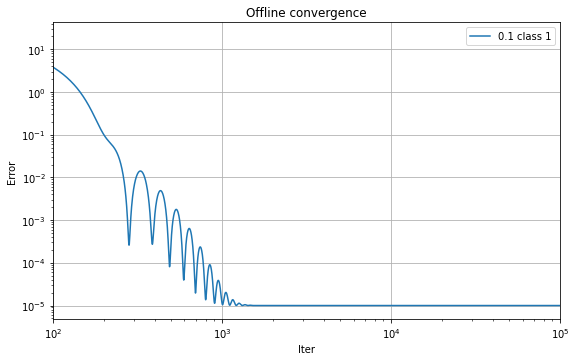

In [425]:
from matplotlib import gridspec
from plotting import *
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
add_fill_lines(ax1, np.arange(iters), np.array([err]), plot_kwargs = {"label": "0.1 class 1"})
plt.legend()
plt.title("Offline convergence")
plt.ylabel("Error")
plt.xlabel("Iter")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

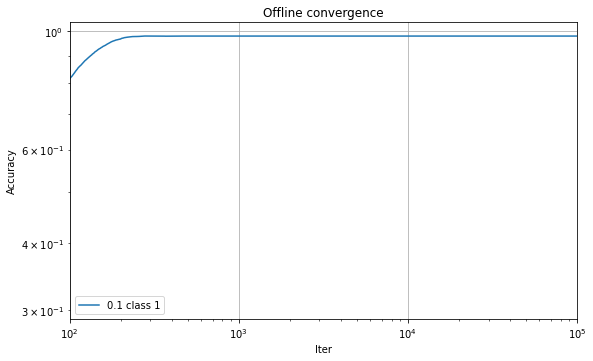

In [426]:
from matplotlib import gridspec
from plotting import *
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
add_fill_lines(ax1, np.arange(iters), np.array([acc]), plot_kwargs = {"label": "0.1 class 1"})
plt.legend()
plt.title("Offline convergence")
plt.ylabel("Accuracy")
plt.xlabel("Iter")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

### Online algorithm

In [427]:
def run_online(params, items, iters, lrs, err, acc):
    
    @jit
    def fit_class0(w, l, mu, zeta, c, l_, x, y, t):
        r = w.T@x
        mu += (x - mu)/t
        zeta += (r-zeta)/t
        c += (r-c)/(2*t)
        w += eta*(mu - l*(r-zeta)*(x-mu))
        l += gamma*((r-zeta)**2 - 1)
        l_ += 1.0
        
        return w, l, r, c, mu, zeta, l_ 
    
    @jit
    def fit_class1(w, l, mu, zeta, c, l_, x, y, t):
        r = w.T@x
        c += (l_*r - c)/(2*t)
        w -= eta*l_*x
        l_ = 1.0
        
        return w, l, r, c, mu, zeta, l_ 
    
    
    @jit
    def fit(w, l, mu, zeta, c, l_, x, y, t):
        
        w, l, r, c, mu, zeta, l_  = lax.cond(y[1] == 0, fit_class0, fit_class1, w, l, mu, zeta, c, l_, x, y, t)
        
        return w, l, r, c, mu, zeta, l_
    
    @jit
    def eval_class0(r, c):
        return r > c
    @jit
    def eval_class1(r, c):
        return r < c
    
    
    
    @jit
    def track(y, w, r, c, err, acc, i_iter):
        err_i = (norm(w - w_opt))**2
        acc_i = lax.cond((y[1] == 0), eval_class0, eval_class1, r, c)
        
#         err = err.at[i_iter].set(err_i)
#         acc = acc.at[i_iter].set(acc_i)
        return err_i, acc_i
    
    class_0, class_1, X, Y, mu_0, mu_1, Sigma = items
    eta, gamma = lrs
    
    mu, w, l, c, zeta, l_, w_opt = params
        
    for i_epoch in tqdm(range(epochs)):

        idx = onp.random.permutation(samples)
            
        Xp = X[:,idx].T
        Yp = Y[:,idx].T
        
        for i_sample, (x, y) in enumerate(zip(Xp, Yp)):
            
            i_iter = i_epoch*samples + i_sample
            t = i_iter + 1

            w, l, r, c, mu, zeta, l_ = fit(w, l, mu, zeta, c, l_, x, y, t)

            err_i, acc_i = track(y, w, r, c, err, acc, i_iter)
            err[i_iter] = err_i
            acc[i_iter] = acc_i
            
        
        #print(((w.T@class_0 > 1/2 * w.T@(mu_0+mu_1)).sum()  + (w.T@class_1 < 1/2 * w.T@(mu_0+mu_1)).sum())/samples)
        
        
    return w_opt, w, l, err, acc

In [428]:
eta = 1e-5; gamma=1e2*eta; epochs = int(10)

err = onp.zeros(epochs*samples)
acc = onp.zeros(epochs*samples)

mu = np.zeros(x_dim)
w = np.array(onp.random.randn(x_dim)/onp.sqrt(x_dim))
l = 1.0
c = 0.0
zeta = 0.0
l_ = 1.0

params = mu, w, l, c, zeta, l_, w_opt

In [429]:
w_opt, w, l, err, acc = run_online(params, items, iters, (eta, gamma), err, acc)

100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


In [430]:
w, w_opt

(DeviceArray([ 1.004224  , -0.35784808, -0.45383465,  1.0078442 ,
               0.81575024], dtype=float32),
 DeviceArray([[ 2.727689 ],
              [-2.1984105],
              [-1.5351883],
              [ 1.8389577],
              [ 1.8337816]], dtype=float32))

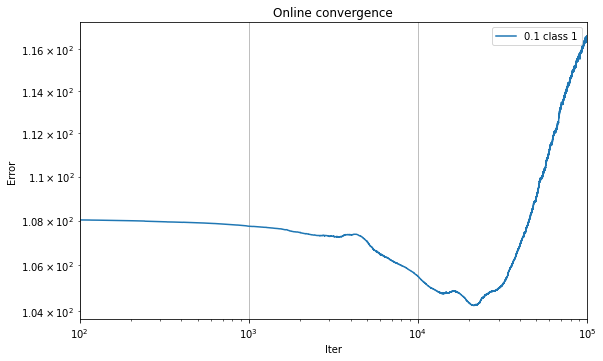

In [401]:
from matplotlib import gridspec
from plotting import *
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
add_fill_lines(ax1, np.arange(epochs*samples), np.array([err]), plot_kwargs = {"label": "0.1 class 1"})
plt.legend()
plt.title("Online convergence")
plt.ylabel("Error")
plt.xlabel("Iter")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

/Users/aneeshkashalikar/.pyenv/versions/3.7.10/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


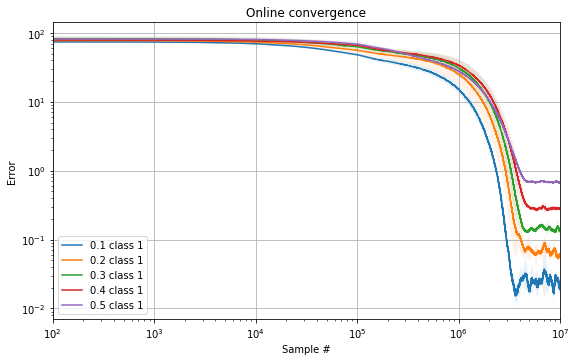

In [291]:
from matplotlib import gridspec
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])

add_fill_lines(ax1, range(iters), np.array(err1s), plot_kwargs = {"label": "0.1 class 1"})
add_fill_lines(ax1, range(iters), np.array(err2s), plot_kwargs = {"label": "0.2 class 1"})
add_fill_lines(ax1, range(iters), np.array(err3s), plot_kwargs = {"label": "0.3 class 1"})
add_fill_lines(ax1, range(iters), np.array(err4s), plot_kwargs = {"label": "0.4 class 1"})
add_fill_lines(ax1, range(iters), np.array(err5s), plot_kwargs = {"label": "0.5 class 1"})
plt.legend()
plt.title("Online convergence")
plt.ylabel("Error")
plt.xlabel("Sample #")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

In [280]:
acc5s

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 

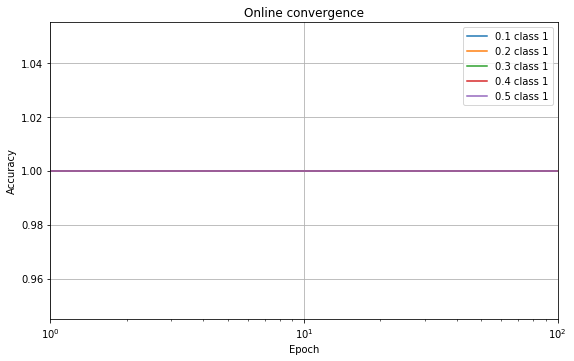

In [288]:
from matplotlib import gridspec
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])

add_fill_lines(ax1, range(epochs), np.array(acc1s), plot_kwargs = {"label": "0.1 class 1"})
add_fill_lines(ax1, range(epochs), np.array(acc2s), plot_kwargs = {"label": "0.2 class 1"})
add_fill_lines(ax1, range(epochs), np.array(acc3s), plot_kwargs = {"label": "0.3 class 1"})
add_fill_lines(ax1, range(epochs), np.array(acc4s), plot_kwargs = {"label": "0.4 class 1"})
add_fill_lines(ax1, range(epochs), np.array(acc5s), plot_kwargs = {"label": "0.5 class 1"})
plt.legend()
plt.title("Online convergence")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.xlim(1,epochs)
plt.grid()
plt.show()

In [ ]:
# plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
# plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
# plt.grid()
# plt.show()